In [1]:
import pandas as pd
import numpy as np
import os as os
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Pick up the date we grabbed in our acquisition. Don't really need to rebalance often, so it doesn't make sense to pull via sdk and 
# waste the message count of whatever service we use. 

file_path = Path('Resources/MSR_sp500_5yr_close.csv')

sp500_close = pd.read_csv(file_path,
                         parse_dates=True,
                         index_col = 'date',
                         infer_datetime_format=True)
sp500_close.head()

,date.1,date.2,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-04-06 00:00:00+00:00,2015-04-06T00:00:00.000Z,5.10,165.48,46.30,57.61,70.87,95.69,22.670,76.23,2.70,...,NaN,130.72,35.05,12.95,41.990,36.07,79.73,117.36,26.900,46.33
2015-04-07 00:00:00+00:00,2015-04-07T00:00:00.000Z,5.12,166.21,46.19,58.42,69.73,96.39,22.770,75.65,2.70,...,NaN,127.88,34.51,12.96,42.330,36.07,78.29,116.01,27.210,46.36
2015-04-08 00:00:00+00:00,2015-04-08T00:00:00.000Z,5.19,166.27,46.61,58.81,69.63,95.12,22.960,75.44,2.71,...,NaN,129.28,34.43,13.10,42.550,35.25,78.30,116.12,27.270,46.21
2015-04-09 00:00:00+00:00,2015-04-09T00:00:00.000Z,5.28,166.79,47.00,60.32,69.80,95.47,23.000,76.33,2.72,...,NaN,136.63,34.32,13.13,43.325,34.96,78.92,117.20,27.535,46.55
2015-04-10 00:00:00+00:00,2015-04-10T00:00:00.000Z,5.28,167.07,47.15,62.00,69.35,94.69,22.925,76.53,2.76,...,NaN,136.02,34.67,13.26,43.830,35.20,80.02,117.45,27.330,47.17


In [3]:
#sp500_full['symbol'].unique()

## Overall Approach
1. Identify the investable universe. For this data sample, we chose the S&P500 of 2019. 
2. Create the Generic Momentum Screen. We rank firms within our universe based on their past 12-month returns, ignoring the last month. 
3. Momentum Quality Screen: WE screen high-mom firms on the quality of the mom, which is measured by the FIP algorithm. (detailed below)
4. Momentum Seasonality Screen: take advantage of the seasonal aspects applicable to MoM investing, which determines the timing of the rebalance. We rebalance quarterly before quarter ending months. 
5. Invest with conviction: We invest in a concentrated portfolo of stocks with teh highest quality momentum. 

A hypothetical portfolio construction scenario would work in the following way. Consider a universe of 1,000 stocks identified in step 1. In step 2, we calculate generic momentum scores for each of the 1,000 securities and identify the top 10 percent, or 100 highest generic momentum stocks. For step 3, we calculate the FIP score for the 100 high-momentum names identified in step 2 and rank these 100 stocks on FIP, where lower is better. We identify the top half, or 50 high-momentum stocks with the smoothest momentum. In step 4, we determine the model portfolio and conduct our rebalance at the end of February, May, August, and November to exploit seasonality effects. Finally, in step 5, we implement the roughly 50-stock portfolio strategy with an equal-weight construction (to minimize stock specific risk) and prepare for high relative performance volatility and the blessing (and curse) of long periods of relative outperformance (and underperformance). 

Gray, Wesley R.; Vogel, Jack R.. Quantitative Momentum: A Practitioner's Guide to Building a Momentum-Based Stock Selection System (Wiley Finance) (Kindle Locations 3617-3623). 

## Generic Momentum Screen

In this step, we will apply the generic momentum screen on monthly returns calculated from daily returns, removing the last month. 

In [4]:
#end of dataset for determining FIP
last_day = "2020-03-02 00:00:00+00:00"
end = (sp500_close.index.get_loc(last_day))-len(sp500_close)
end

-25

In [5]:
mid=sp500_close[(end+(-21*12)):(end-21)]
mid.tail()

,date.1,date.2,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-01-23 00:00:00+00:00,NaN,NaN,177.74,90.73,85.27,184.46,210.68,60.13,351.76,51.71,...,206.66,139.11,66.90,36.23,102.41,82.36,105.98,149.51,47.79,138.34
2020-01-24 00:00:00+00:00,NaN,NaN,178.15,90.40,83.54,182.98,208.57,59.40,351.37,50.35,...,209.01,134.75,67.17,35.52,100.80,81.48,104.98,147.80,46.63,136.31
2020-01-27 00:00:00+00:00,NaN,NaN,175.63,89.59,84.02,181.45,206.55,58.32,346.90,49.26,...,207.43,123.89,66.92,35.05,97.00,80.22,104.39,148.04,46.46,135.96
2020-01-28 00:00:00+00:00,NaN,NaN,165.58,89.54,83.77,187.01,210.24,60.03,354.63,50.53,...,213.00,124.97,67.22,36.78,98.61,81.27,104.82,149.20,47.09,138.26
2020-01-29 00:00:00+00:00,NaN,NaN,162.00,89.14,83.20,188.85,207.96,60.40,351.66,47.51,...,212.66,123.85,67.42,36.73,88.06,83.17,106.63,150.75,46.37,138.51


In [6]:
short=sp500_close[(end+(-21)):(end-5)]
short.tail()

,date.1,date.2,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-02-14 00:00:00+00:00,NaN,NaN,161.01,89.66,94.05,167.22,212.37,63.520,379.67,55.31,...,213.67,132.14,70.26,37.82,90.17,88.14,105.28,160.40,46.26,144.17
2020-02-18 00:00:00+00:00,NaN,NaN,158.88,88.88,93.61,169.00,213.76,63.740,378.85,56.89,...,212.69,133.46,71.16,37.22,89.24,88.05,104.03,159.25,45.09,143.65
2020-02-19 00:00:00+00:00,NaN,NaN,159.34,89.36,94.14,167.90,215.92,64.370,383.28,58.90,...,211.76,136.17,70.79,36.77,90.71,87.96,105.19,160.02,45.81,144.06
2020-02-20 00:00:00+00:00,NaN,NaN,158.56,88.46,94.23,168.08,213.90,64.000,378.96,57.27,...,209.50,133.33,70.67,36.78,89.79,88.66,103.87,158.39,46.25,143.55
2020-02-21 00:00:00+00:00,NaN,NaN,156.93,87.45,94.96,166.74,211.89,63.375,372.95,53.28,...,208.44,127.95,70.82,36.34,87.72,88.52,103.51,157.39,45.43,142.23


In [7]:
overall_returns_mid=mid.pct_change()
cum_returns_mid=((1+overall_returns_mid).cumprod()-1).iloc[[-1]]

overall_returns_short=short.pct_change()
cum_returns_short=((1+overall_returns_short).cumprod()-1).iloc[[-1]]

## Generic Momentum

In [8]:
#Begin the process of moving the horizontal dataframe back to a vertical dataframe. 
return_list_mid = cum_returns_mid.stack()
return_list_short = cum_returns_short.stack()
return_list_mid

date                           
2020-01-29 00:00:00+00:00  MMM    -0.219239
                           ABT     0.134241
                           ABBV    0.038702
                           ABMD   -0.457421
                           ACN     0.266504
                                     ...   
                           XYL     0.089040
                           YUM     0.118066
                           ZBH     0.202057
                           ZION   -0.093805
                           ZTS     0.446580
Length: 502, dtype: float64

In [9]:
df_mid = return_list_mid.to_frame().reset_index()
df_short = return_list_short.to_frame().reset_index()
df_mid.head()

,date,level_1,0
0,2020-01-29 00:00:00+00:00,MMM,-0.219239
1,2020-01-29 00:00:00+00:00,ABT,0.134241
2,2020-01-29 00:00:00+00:00,ABBV,0.038702
3,2020-01-29 00:00:00+00:00,ABMD,-0.457421
4,2020-01-29 00:00:00+00:00,ACN,0.266504


In [10]:
df_mid.rename(columns ={0:"return","level_1":"symbol"}, inplace = True)
df_short.rename(columns ={0:"return","level_1":"symbol"}, inplace = True)

In [11]:
df_mid.drop(columns=['date'], inplace=True)
df_short.drop(columns=['date'], inplace=True)

In [12]:
df_mid.set_index(df_mid['symbol'], inplace = True)
df_short.set_index(df_short['symbol'], inplace = True)

In [13]:
df_mid.drop(columns=['symbol'], inplace=True)
df_short.drop(columns=['symbol'], inplace=True)

In [14]:
df_mid.sort_values(['return'],ascending=False,inplace=True)
df_short.sort_values(['return'],ascending=False,inplace=True)

In [15]:
df_mid['decile_rank']=pd.qcut(df_mid['return'],10,labels=False)
df_short['decile_rank']=pd.qcut(df_short['return'],10,labels=False)

In [16]:
df_mid.sort_values(['decile_rank'],ascending=False,inplace=True)
top_decile_mid=df_mid.loc[df_mid['decile_rank']==9]

df_short.sort_values(['decile_rank'],ascending=False,inplace=True)
top_decile_short=df_short.loc[df_short['decile_rank']==9]

In [17]:
top_decile_mid

,return,decile_rank
symbol,,
AMD,1.006334,9
SNPS,0.457893,9
MKTX,0.448188,9
ZTS,0.446580,9
LEN,0.441208,9
SWKS,0.438034,9
CMG,0.437634,9
ALLE,0.434430,9
CAG,0.427343,9


In [18]:
top_decile_short

,return,decile_rank
symbol,,
TMUS,0.217816,9
AMD,0.092251,9
HES,0.100068,9
NEM,0.099400,9
J,0.099164,9
DLR,0.098537,9
CL,0.097884,9
DISH,0.097844,9
IBM,0.095562,9


## FIP = sign(Past return) * [% negative - % positive]

In [19]:
#Cam - before we do this step we need to (1) bin and take the top decile. Need to drop the date, bin, and then determine the tickers
# that have the top returns. Then we need to take those returns and come back through this process. 

# The signal here is that we need to remove "low quality" momentum. Stocks that "pop" are shown to be overpriced and generally under-
# perform. The underperformance is the result of mispricing caused by biased investors whom overpay for lottery-like stocks. 

# The more negative the FIP, the better. We are seperating high momentum stocks into those that have more continuous price paths. 
    # If FIP scores are positive, then automatically the security had poor returns over the last year (it was a negative number). 
    # If FIP is a little negative, it had positive returns, but a bumpy ride. 
    # If FIP is very negative, then smoother path, which reflects the behavioral irrational decision making of "lack of attention". 
    # The lack of attention is the best momentum, where these securities are more likely to suffer from why momentum stocks outperform:
    # investors are systematically underreacting to positive news. 

fip_scores_mid = []
for column in overall_returns_mid.columns:
    num_positive_mid = len(overall_returns_mid.loc[overall_returns_mid[column] > 0])
    num_negative_mid = len(overall_returns_mid.loc[overall_returns_mid[column] < 0])
    num_zero_mid = len(overall_returns_mid.loc[overall_returns_mid[column] == 0])
    num_days_mid = len(overall_returns_mid)
    cum_returns_mid = overall_returns_mid[column].sum() # this will be deprecated to calculate Generic Momentum, which will be past year minus
                                                # most recent month. 
    
    fip_score_mid = np.sign(cum_returns_mid) * (num_negative_mid / num_days_mid - num_positive_mid/num_days_mid)
    
    fip_scores_mid.append(fip_score_mid)
    
fip_scores_short = []
for column in overall_returns_short.columns:
    num_positive_short = len(overall_returns_short.loc[overall_returns_short[column] > 0])
    num_negative_short = len(overall_returns_short.loc[overall_returns_short[column] < 0])
    num_zero_short = len(overall_returns_short.loc[overall_returns_short[column] == 0])
    num_days_short = len(overall_returns_short)
    cum_returns_short = overall_returns_short[column].sum() # this will be deprecated to calculate Generic Momentum, which will be past year minus
                                                # most recent month. 
    
    fip_score_short = np.sign(cum_returns_short) * (num_negative_short / num_days_short - num_positive_short/num_days_short)
    
    fip_scores_short.append(fip_score_short)

In [20]:
# we need to get tie the fip scores to the index of tickers, and sort the fip scores

In [21]:
# for i, column in enumerate(overall_returns.columns):
#     print(f"{column}, fip_score: {fip_scores[i]}")

In [22]:
# overall_returns

In [23]:
fip_scores_series_mid = pd.Series(fip_scores_mid, index = overall_returns_mid.columns)
fip_scores_series_mid.name = "fip_scores_mid"

fip_scores_series_short = pd.Series(fip_scores_short, index = overall_returns_short.columns)
fip_scores_series_short.name = "fip_scores_short"

In [24]:
fip_scores_series_mid

date.1    0.000000
date.2    0.000000
MMM      -0.043290
ABT      -0.125541
ABBV     -0.043290
            ...   
XYL      -0.056277
YUM      -0.086580
ZBH      -0.051948
ZION      0.082251
ZTS      -0.155844
Name: fip_scores_mid, Length: 505, dtype: float64

In [25]:
import plotly.express as px
import seaborn as sns

In [26]:
x_mid = top_decile_mid.merge(fip_scores_series_mid, right_index = True, left_index = True).sort_values(by = 'fip_scores_mid', ascending = True)[:5]
x_short = top_decile_short.merge(fip_scores_series_short, right_index = True, left_index = True).sort_values(by = 'fip_scores_short', ascending = True)[:5]

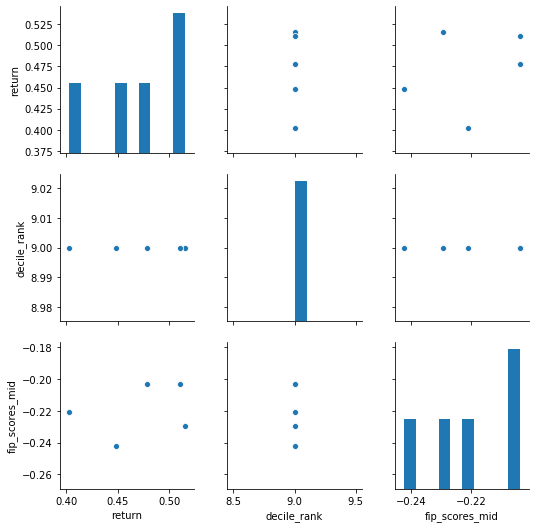

In [27]:
sns.pairplot(x_mid)

In [28]:
x_mid

,return,decile_rank,fip_scores_mid
MKTX,0.448188,9,-0.242424
GPN,0.515476,9,-0.229437
SO,0.402561,9,-0.220779
WU,0.510708,9,-0.203463
INFO,0.478140,9,-0.203463


In [29]:
x_short

,return,decile_rank,fip_scores_short
EQIX,0.087877,9,-0.5625
JKHY,0.117201,9,-0.4375
AMD,0.092251,9,-0.4375
AMG,0.105466,9,-0.4375
NEM,0.099400,9,-0.4375


In [30]:
mid_stocks=pd.DataFrame()
for i in sp500_close.columns:
    if i in x_mid.index:
        mid_stocks[i]=sp500_close[i]
        

In [31]:
short_stocks=pd.DataFrame()
for i in sp500_close.columns:
    if i in x_short.index:
        short_stocks[i]=sp500_close[i]

In [32]:
#create a CSV file to save the data - short
x_short.to_csv('Resources/mom_fip_scores_short.csv')
#create a CSV file to save the data - mid
x_mid.to_csv('Resources/mom_fip_scores_mid.csv')

In [33]:
#determine last price from test +1
short_last_day_loc = short_stocks.index.get_loc(last_day)
last_price = short_stocks.iloc[short_last_day_loc]
last_price

AMD      47.46
AMG      78.36
EQIX    618.88
JKHY    158.73
NEM      46.83
Name: 2020-03-02 00:00:00+00:00, dtype: float64

In [34]:
#determi portfolio weight based on last trade day and $1000 investment
portfolio_weights = []
for ticker in last_price:
    weight = 200/ticker
    portfolio_weights.append(weight)

In [35]:
portfolio_weights

[4.214075010535187,
 2.5523226135783563,
 0.3231644260599793,
 1.26000126000126,
 4.270766602605168]

In [36]:
#create a column for portfolio value over time based on weight of stocks above
short_stocks["portfolio_value"] = short_stocks.dot(portfolio_weights)

In [37]:
#create a columns for percent change 1 day and 5 days
short_stocks["port_val_chg_1_days"] = short_stocks.portfolio_value.pct_change(periods=1)
short_stocks["port_val_chg_5_days"] = short_stocks.portfolio_value.pct_change(periods=5)

In [38]:
#create a column for portfolio value over time based on weight of stocks above
bin_list = []
bin_list = short_stocks["port_val_chg_5_days"].tolist()
bin_calc = [1 if v >= 0 else 0 for v in bin_list]
short_stocks["port_val_chg_5_days_bin"] = bin_calc

In [39]:
short_stocks.head(10)

,AMD,AMG,EQIX,JKHY,NEM,portfolio_value,port_val_chg_1_days,port_val_chg_5_days,port_val_chg_5_days_bin
date,,,,,,,,,
2015-04-06 00:00:00+00:00,2.700,215.14,235.15,70.09,22.58,821.224203,NaN,NaN,0
2015-04-07 00:00:00+00:00,2.700,214.17,234.29,69.33,22.17,815.761913,-0.006651,NaN,0
2015-04-08 00:00:00+00:00,2.710,215.74,239.09,69.07,22.08,820.650420,0.005993,NaN,0
2015-04-09 00:00:00+00:00,2.720,218.70,240.06,68.42,22.23,828.382520,0.009422,NaN,0
2015-04-10 00:00:00+00:00,2.760,217.70,239.65,68.03,22.33,825.801939,-0.003115,NaN,0
2015-04-13 00:00:00+00:00,2.780,219.10,239.77,68.15,22.57,830.674436,0.005900,0.011507,1
2015-04-14 00:00:00+00:00,2.670,219.86,241.49,68.41,22.82,834.101787,0.004126,0.022482,1
2015-04-15 00:00:00+00:00,2.700,219.51,241.19,67.62,23.55,835.360206,0.001509,0.017925,1
2015-04-16 00:00:00+00:00,2.870,219.93,241.56,67.33,23.62,837.201698,0.002204,0.010646,1


In [40]:
#create csv of close prices and portfolio weight for chosen stocks
#mid_stocks.to_csv('Resources/sp500_mom_mid.csv')
short_stocks.dropna(inplace=True)
short_stocks.to_csv('Resources/sp500_mom_short.csv')

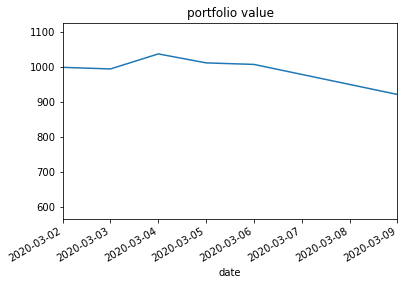

In [83]:
#chart results
short_stocks.portfolio_value.plot(title="portfolio value",xlim=("2020-03-02 00:00:00+00:00","2020-03-09 00:00:00+00:00"))

In [42]:
short_stocks.tail(30)

,AMD,AMG,EQIX,JKHY,NEM,portfolio_value,port_val_chg_1_days,port_val_chg_5_days,port_val_chg_5_days_bin
date,,,,,,,,,
2020-02-24 00:00:00+00:00,49.12,85.28,644.90,167.93,50.26,1059.306916,-0.027921,-0.000015,0
2020-02-25 00:00:00+00:00,47.57,82.33,631.98,163.75,49.14,1031.020400,-0.026703,-0.038873,0
2020-02-26 00:00:00+00:00,47.49,81.68,629.84,160.55,49.40,1025.411088,-0.005441,-0.062475,0
2020-02-27 00:00:00+00:00,44.01,80.28,597.49,154.55,46.53,976.901378,-0.047308,-0.112698,0
2020-02-28 00:00:00+00:00,45.48,75.22,572.80,151.74,44.63,950.547326,-0.026977,-0.127725,0
2020-03-02 00:00:00+00:00,47.46,78.36,618.88,158.73,46.83,1000.000000,0.052025,-0.055987,0
2020-03-03 00:00:00+00:00,46.75,73.81,615.16,157.79,49.73,995.393589,-0.004606,-0.034555,0
2020-03-04 00:00:00+00:00,50.11,75.42,645.49,165.40,51.00,1038.476181,0.043282,0.012741,1
2020-03-05 00:00:00+00:00,48.11,70.70,616.67,164.99,52.08,1012.783297,-0.024741,0.036730,1


---


---

# Generic Momentum Screen for 2nd Week Projection

In [43]:
#end of dataset for determining FIP
last_day_wk2 = "2020-03-09 00:00:00+00:00"
end2 = (sp500_close.index.get_loc(last_day_wk2))-len(sp500_close)
end2

-20

In [44]:
mid2=sp500_close[(end2+(-21*12)):(end2-21)]
mid2.tail()

,date.1,date.2,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-01-30 00:00:00+00:00,NaN,NaN,162.51,89.16,81.78,186.85,208.37,60.89,356.74,48.78,...,214.75,126.62,68.76,36.98,87.20,83.66,106.60,151.18,46.760,138.03
2020-01-31 00:00:00+00:00,NaN,NaN,158.66,87.14,81.02,186.29,205.21,58.48,351.14,47.00,...,211.29,126.16,69.19,35.57,84.48,81.66,105.77,147.90,45.490,134.21
2020-02-03 00:00:00+00:00,NaN,NaN,156.59,87.06,82.30,185.95,207.80,58.21,358.00,48.02,...,215.11,128.58,69.45,36.29,85.05,83.34,106.41,148.51,46.105,135.52
2020-02-04 00:00:00+00:00,NaN,NaN,157.24,88.23,84.36,190.90,212.53,59.21,366.74,49.45,...,218.57,132.70,69.30,36.57,85.78,86.51,106.71,156.77,46.680,138.97
2020-02-05 00:00:00+00:00,NaN,NaN,162.33,89.56,86.63,190.73,212.22,58.85,365.55,49.84,...,220.06,132.28,69.30,37.62,88.23,87.61,106.78,157.70,48.010,137.89


In [45]:
short2=sp500_close[(end2+(-21)):(end2-5)]
short2.tail()

,date.1,date.2,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24 00:00:00+00:00,NaN,NaN,152.55,84.63,93.14,165.29,204.36,62.31,357.41,49.12,...,205.54,120.17,70.37,34.86,85.18,86.43,100.25,154.33,43.760,138.39
2020-02-25 00:00:00+00:00,NaN,NaN,146.85,81.13,89.18,158.80,197.10,59.51,347.80,47.57,...,202.64,113.89,68.84,36.46,83.88,84.33,97.95,149.73,42.380,134.82
2020-02-26 00:00:00+00:00,NaN,NaN,148.96,81.36,88.41,154.09,195.67,59.37,351.34,47.49,...,204.44,110.75,68.35,35.73,82.60,83.93,97.50,146.56,41.815,136.15
2020-02-27 00:00:00+00:00,NaN,NaN,150.16,79.19,85.42,153.97,186.44,58.33,337.52,44.01,...,194.53,111.16,64.85,33.83,79.49,80.66,92.67,139.95,40.590,133.95
2020-02-28 00:00:00+00:00,NaN,NaN,149.24,77.03,85.71,150.26,180.59,58.13,345.12,45.48,...,189.25,107.98,62.32,32.20,83.49,77.34,89.25,136.15,39.950,133.23


In [46]:
overall_returns_mid2=mid2.pct_change()
cum_returns_mid2=((1+overall_returns_mid2).cumprod()-1).iloc[[-1]]

overall_returns_short2=short2.pct_change()
cum_returns_short2=((1+overall_returns_short2).cumprod()-1).iloc[[-1]]

## Generic Momentum

In [47]:
#Begin the process of moving the horizontal dataframe back to a vertical dataframe. 
return_list_mid2 = cum_returns_mid2.stack()
return_list_short2 = cum_returns_short2.stack()
return_list_mid2

date                           
2020-02-05 00:00:00+00:00  MMM    -0.191946
                           ABT     0.168733
                           ABBV    0.116654
                           ABMD   -0.392986
                           ACN     0.312512
                                     ...   
                           XYL     0.166889
                           YUM     0.104583
                           ZBH     0.296768
                           ZION   -0.014168
                           ZTS     0.492155
Length: 502, dtype: float64

In [48]:
df_mid2 = return_list_mid2.to_frame().reset_index()
df_short2 = return_list_short2.to_frame().reset_index()
df_mid2.head()

,date,level_1,0
0,2020-02-05 00:00:00+00:00,MMM,-0.191946
1,2020-02-05 00:00:00+00:00,ABT,0.168733
2,2020-02-05 00:00:00+00:00,ABBV,0.116654
3,2020-02-05 00:00:00+00:00,ABMD,-0.392986
4,2020-02-05 00:00:00+00:00,ACN,0.312512


In [49]:
df_mid2.rename(columns ={0:"return","level_1":"symbol"}, inplace = True)
df_short2.rename(columns ={0:"return","level_1":"symbol"}, inplace = True)

In [50]:
df_mid2.drop(columns=['date'], inplace=True)
df_short2.drop(columns=['date'], inplace=True)

In [51]:
df_mid2.set_index(df_mid2['symbol'], inplace = True)
df_short2.set_index(df_short2['symbol'], inplace = True)

In [52]:
df_mid2.drop(columns=['symbol'], inplace=True)
df_short2.drop(columns=['symbol'], inplace=True)

In [53]:
df_mid2.sort_values(['return'],ascending=False,inplace=True)
df_short2.sort_values(['return'],ascending=False,inplace=True)

In [54]:
df_mid2['decile_rank']=pd.qcut(df_mid2['return'],10,labels=False)
df_short2['decile_rank']=pd.qcut(df_short2['return'],10,labels=False)

In [55]:
df_mid2.sort_values(['decile_rank'],ascending=False,inplace=True)
top_decile_mid2=df_mid2.loc[df_mid2['decile_rank']==9]

df_short2.sort_values(['decile_rank'],ascending=False,inplace=True)
top_decile_short2=df_short2.loc[df_short2['decile_rank']==9]

In [56]:
top_decile_mid2

,return,decile_rank
symbol,,
AMD,1.264425,9
KLAC,0.503115,9
SNPS,0.494283,9
SWKS,0.493074,9
ZTS,0.492155,9
FTNT,0.484815,9
MA,0.479785,9
DHI,0.477228,9
CDW,0.473889,9


In [57]:
top_decile_short2

,return,decile_rank
symbol,,
REGN,0.140362,9
ES,-0.048531,9
ZTS,-0.041304,9
SJM,-0.044354,9
LH,-0.044540,9
NOW,-0.045683,9
AMT,-0.046297,9
K,-0.047116,9
IRM,-0.047604,9


## FIP = sign(Past return) * [% negative - % positive]

In [58]:
#Cam - before we do this step we need to (1) bin and take the top decile. Need to drop the date, bin, and then determine the tickers
# that have the top returns. Then we need to take those returns and come back through this process. 

# The signal here is that we need to remove "low quality" momentum. Stocks that "pop" are shown to be overpriced and generally under-
# perform. The underperformance is the result of mispricing caused by biased investors whom overpay for lottery-like stocks. 

# The more negative the FIP, the better. We are seperating high momentum stocks into those that have more continuous price paths. 
    # If FIP scores are positive, then automatically the security had poor returns over the last year (it was a negative number). 
    # If FIP is a little negative, it had positive returns, but a bumpy ride. 
    # If FIP is very negative, then smoother path, which reflects the behavioral irrational decision making of "lack of attention". 
    # The lack of attention is the best momentum, where these securities are more likely to suffer from why momentum stocks outperform:
    # investors are systematically underreacting to positive news. 

fip_scores_mid2 = []
for column in overall_returns_mid2.columns:
    num_positive_mid2 = len(overall_returns_mid2.loc[overall_returns_mid2[column] > 0])
    num_negative_mid2 = len(overall_returns_mid2.loc[overall_returns_mid2[column] < 0])
    num_zero_mid2 = len(overall_returns_mid2.loc[overall_returns_mid2[column] == 0])
    num_days_mid2 = len(overall_returns_mid2)
    cum_returns_mid2 = overall_returns_mid2[column].sum() # this will be deprecated to calculate Generic Momentum, which will be past year minus
                                                # most recent month. 
    
    fip_score_mid2 = np.sign(cum_returns_mid2) * (num_negative_mid2 / num_days_mid2 - num_positive_mid2/num_days_mid2)
    
    fip_scores_mid2.append(fip_score_mid2)
    
fip_scores_short2 = []
for column in overall_returns_short2.columns:
    num_positive_short2 = len(overall_returns_short2.loc[overall_returns_short2[column] > 0])
    num_negative_short2 = len(overall_returns_short2.loc[overall_returns_short2[column] < 0])
    num_zero_short2 = len(overall_returns_short2.loc[overall_returns_short2[column] == 0])
    num_days_short2 = len(overall_returns_short2)
    cum_returns_short2 = overall_returns_short2[column].sum() # this will be deprecated to calculate Generic Momentum, which will be past year minus
                                                # most recent month. 
    
    fip_score_short2 = np.sign(cum_returns_short2) * (num_negative_short2 / num_days_short2 - num_positive_short2/num_days_short2)
    
    fip_scores_short2.append(fip_score_short2)

In [59]:
# we need to get tie the fip scores to the index of tickers, and sort the fip scores

In [60]:
# for i, column in enumerate(overall_returns.columns):
#     print(f"{column}, fip_score: {fip_scores[i]}")

In [61]:
# overall_returns

In [62]:
fip_scores_series_mid2 = pd.Series(fip_scores_mid2, index = overall_returns_mid2.columns)
fip_scores_series_mid2.name = "fip_scores_mid2"

fip_scores_series_short2 = pd.Series(fip_scores_short2, index = overall_returns_short2.columns)
fip_scores_series_short2.name = "fip_scores_short2"

In [63]:
fip_scores_series_mid2

date.1    0.000000
date.2    0.000000
MMM      -0.025974
ABT      -0.142857
ABBV     -0.060606
            ...   
XYL      -0.090909
YUM      -0.086580
ZBH      -0.077922
ZION     -0.116883
ZTS      -0.164502
Name: fip_scores_mid2, Length: 505, dtype: float64

In [64]:
import plotly.express as px
import seaborn as sns

In [65]:
x_mid2 = top_decile_mid2.merge(fip_scores_series_mid2, right_index = True, left_index = True).sort_values(by = 'fip_scores_mid2', ascending = True)[:5]
x_short2 = top_decile_short2.merge(fip_scores_series_short2, right_index = True, left_index = True).sort_values(by = 'fip_scores_short2', ascending = True)[:5]

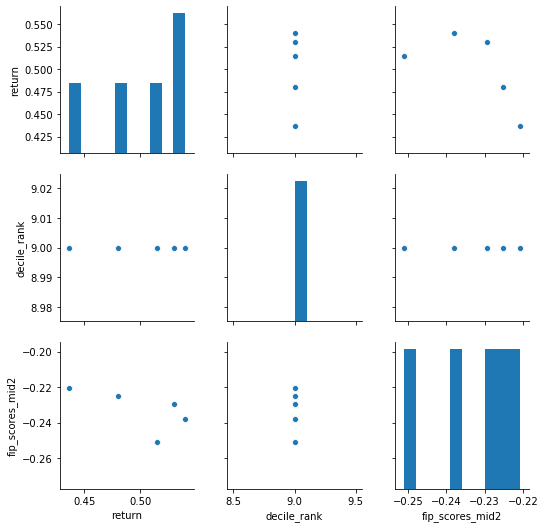

In [66]:
sns.pairplot(x_mid2)

In [67]:
x_mid2

,return,decile_rank,fip_scores_mid2
MKTX,0.514823,9,-0.251082
GPN,0.539672,9,-0.238095
INFO,0.529501,9,-0.229437
MA,0.479785,9,-0.225108
EFX,0.436377,9,-0.220779


In [68]:
x_short2

,return,decile_rank,fip_scores_short2
ICE,-0.009877,9,-0.4375
REGN,0.140362,9,-0.3125
AAP,-0.010345,9,-0.3125
XLNX,-0.048222,9,-0.3125
K,-0.047116,9,-0.3125


In [69]:
mid_stocks2=pd.DataFrame()
for i in sp500_close.columns:
    if i in x_mid2.index:
        mid_stocks2[i]=sp500_close[i]
        

In [70]:
short_stocks2=pd.DataFrame()
for i in sp500_close.columns:
    if i in x_short2.index:
        short_stocks2[i]=sp500_close[i]

In [71]:
#create a CSV file to save the data - short
x_short2.to_csv('Resources/mom_fip_scores_short_wk2.csv')
#create a CSV file to save the data - mid
x_mid2.to_csv('Resources/mom_fip_scores_mid_wk2.csv')

In [72]:
#determine last price from test +1
short_last_day_loc2 = short_stocks2.index.get_loc(last_day_wk2)
last_price2 = short_stocks2.iloc[short_last_day_loc2]
last_price2

AAP     130.36
ICE      88.62
K        62.41
REGN    474.44
XLNX     73.68
Name: 2020-03-09 00:00:00+00:00, dtype: float64

In [73]:
#determin new investment
last_day_wk2
rebalance_loc = (short_stocks.index.get_loc(last_day_wk2))
rebalance_amount = short_stocks.portfolio_value.iloc[rebalance_loc]/5
rebalance_amount

184.47251253485672

In [74]:
#determine portfolio weight based on last trade day and $1000 investment
portfolio_weights2 = []
for ticker in last_price2:
    weight2 = rebalance_amount/ticker
    portfolio_weights2.append(weight2)

In [75]:
portfolio_weights2

[1.415100587103841,
 2.081612644266043,
 2.9558165764277637,
 0.3888215844677024,
 2.503698595749955]

In [76]:
#create a column for portfolio value over time based on weight of stocks above
short_stocks2["portfolio_value"] = short_stocks2.dot(portfolio_weights2)

In [77]:
#create a columns for percent change 1 day and 5 days
short_stocks2["port_val_chg_1_days"] = short_stocks2.portfolio_value.pct_change(periods=1)
short_stocks2["port_val_chg_5_days"] = short_stocks2.portfolio_value.pct_change(periods=5)

In [78]:
#create a column for portfolio value over time based on weight of stocks above
bin_list2 = []
bin_list2 = short_stocks2["port_val_chg_5_days"].tolist()
bin_calc2 = [1 if v >= 0 else 0 for v in bin_list2]
short_stocks2["port_val_chg_5_days_bin"] = bin_calc2

In [79]:
short_stocks2.head(10)

,AAP,ICE,K,REGN,XLNX,portfolio_value,port_val_chg_1_days,port_val_chg_5_days,port_val_chg_5_days_bin
date,,,,,,,,,
2015-04-06 00:00:00+00:00,145.73,229.33,66.03,440.23,41.990,1155.072635,NaN,NaN,0
2015-04-07 00:00:00+00:00,146.71,229.81,65.74,441.65,42.330,1158.004805,0.002539,NaN,0
2015-04-08 00:00:00+00:00,148.81,230.50,65.59,453.19,42.550,1167.007271,0.007774,NaN,0
2015-04-09 00:00:00+00:00,148.05,230.89,65.49,455.04,43.325,1169.107728,0.001800,NaN,0
2015-04-10 00:00:00+00:00,150.20,231.91,65.73,461.39,43.830,1178.716220,0.008219,NaN,0
2015-04-13 00:00:00+00:00,149.18,230.79,65.46,456.98,43.725,1172.165750,-0.005557,0.014798,1
2015-04-14 00:00:00+00:00,149.05,228.88,65.58,455.07,43.135,1166.140773,-0.005140,0.007026,1
2015-04-15 00:00:00+00:00,149.58,229.79,65.17,453.89,43.895,1169.017160,0.002467,0.001722,1
2015-04-16 00:00:00+00:00,150.00,229.88,65.05,457.42,44.325,1171.893280,0.002460,0.002383,1


In [80]:
#create csv of close prices and portfolio weight for chosen stocks
#mid_stocks2.to_csv('Resources/sp500_mom_mid_wk2.csv')
short_stocks2.dropna(inplace=True)
short_stocks2.to_csv('Resources/sp500_mom_short_wk2.csv')

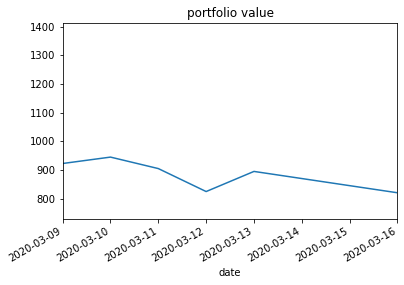

In [82]:
#chart results
short_stocks2.portfolio_value.plot(title="portfolio value",xlim=("2020-03-09 00:00:00+00:00","2020-03-16 00:00:00+00:00"))